In [1]:
import sys
sys.path.insert(0, '../scripts/')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from itertools import count
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# from data_pipeline import clean_dataset
from models import AE, BaselineNet
from utils import gen_y
import seaborn as sns

from imblearn.over_sampling import SMOTE 
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


color = sns.color_palette()

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
scaler = StandardScaler()

In [ ]:
# Load dataset
df = pd.read_csv('../data/denver_prop_listing_clean.csv')

mapping = {k: v for v, k in enumerate(df.property_type.unique())}

# df['dom'] = (df['sale_date'] - df['list_date']).dt.days.astype('int16')
df = df[(df['sqft'] < 6000) & (df['sale_price_per_sqft'] < 500)].copy()
df['property_type_code'] = df['property_type'].map(mapping)

#convert to datetime format
df["list_date"] = pd.to_datetime(df["list_date"])
df["sale_date"] = pd.to_datetime(df["sale_date"])

In [ ]:
y_2019Q2 = gen_y(datetime.timedelta(days = 90), df, datetime.datetime(2019,4,1))
#remove all rows that aren't listed in that period
listed_index = np.where(y_2019Q2[:,0] == 1)
df_2019Q2 = df.iloc[listed_index]

In [ ]:
df_2019Q2

In [ ]:
y_2019Q2.shape

(83830, 2)

In [ ]:
df_2019Q2.shape

(7012, 20)

In [ ]:
#define the X and Y vectors
cols_to_drop = ['property_id', 'zipcode', 'list_date', 'sale_date', 'property_type', 'has_jacuzzi', 'has_garage', 'sale_price', 'ct_key', 'sale_price_per_sqft']
X = df_2019Q2.drop(columns=cols_to_drop)
Y = y_2019Q2[np.where(y_2019Q2[:,0] ==1)]
X.info()

X = X.reset_index(drop=True)

#scale columns

columns_to_scale = ['fips', 'latitude', 'longitude', 'sqft',
                    'full_baths'
                   ]
X[columns_to_scale] =  scaler.fit_transform(X[columns_to_scale])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7012 entries, 10 to 86786
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fips                7012 non-null   float64
 1   latitude            7012 non-null   float64
 2   longitude           7012 non-null   float64
 3   sqft                7012 non-null   float64
 4   has_central_air     7012 non-null   bool   
 5   has_pool            7012 non-null   bool   
 6   has_solar           7012 non-null   bool   
 7   bedrooms            7012 non-null   float64
 8   full_baths          7012 non-null   float64
 9   property_type_code  7012 non-null   int64  
dtypes: bool(3), float64(6), int64(1)
memory usage: 458.8 KB


In [ ]:
Y = Y[:,1]

In [ ]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

In [ ]:
X_train = torch.tensor(X_train.astype(float).values, dtype=torch.float64).to(device)
y_train = torch.tensor(y_train, dtype=torch.int64).to(device)

<AxesSubplot:ylabel='Count'>

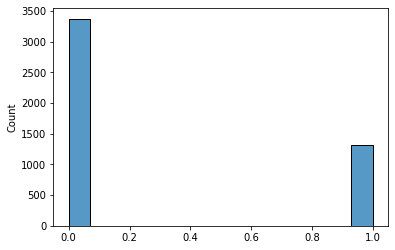

In [ ]:
sns.histplot(y_train.cpu().numpy())

In [ ]:
y_train = torch.nn.functional.one_hot(y_train)

In [ ]:
y_train.shape

torch.Size([4698, 2])

In [ ]:
net = BaselineNet(X_train.shape[1], y_train.shape[1], epochs=20000).to(device)

In [ ]:
net.feed(X_train, y_train)

Iteration: 100. Loss: 0.6271565556526184. Correct: 3376. Accuracy: 71.86036682128906.
Iteration: 200. Loss: 0.5711978673934937. Correct: 3376. Accuracy: 71.86036682128906.
Iteration: 300. Loss: 0.5585663914680481. Correct: 3367. Accuracy: 71.66879272460938.
Iteration: 400. Loss: 0.5562149882316589. Correct: 3377. Accuracy: 71.88165283203125.
Iteration: 500. Loss: 0.5561460852622986. Correct: 3360. Accuracy: 71.5197982788086.
Iteration: 600. Loss: 0.5493397116661072. Correct: 3437. Accuracy: 73.1587905883789.
Iteration: 700. Loss: 0.5391104817390442. Correct: 3464. Accuracy: 73.73350524902344.
Iteration: 800. Loss: 0.535344660282135. Correct: 3502. Accuracy: 74.5423583984375.
Iteration: 900. Loss: 0.5279753804206848. Correct: 3500. Accuracy: 74.49978637695312.
Iteration: 1000. Loss: 0.5305808782577515. Correct: 3492. Accuracy: 74.32949829101562.
Iteration: 1100. Loss: 0.5261304378509521. Correct: 3481. Accuracy: 74.0953598022461.
Iteration: 1200. Loss: 0.5282039046287537. Correct: 3500.

## Joined Dataset (New Dataset from Will)

In [ ]:
joined = pd.read_csv('../data/denver_joined_dataset.csv')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (25,28,36,38,55,56,75,83,97,98,99,100,128,141,142,143,145) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
joined = joined.dropna(axis=1)

In [ ]:
joined.head()

,cc_property_id,zipcode_x,fips_x,sqft,property_type_x,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,...,bathtotalcalc,bathfull,bathsparcialnbr,garageparkingnbr,sumresidentialunits,sumbuildingsnbr,faucidflag,house_market_exists,datatree_exists,property_internal_exists
0,138560546,80002,8059.0,1687.0,SINGLE,False,False,False,False,False,...,3.0,3.0,0.0,1,1.0,0.0,C,True,False,False
1,138555680,80002,8059.0,2220.0,SINGLE,False,False,False,False,False,...,2.0,1.0,1.0,0,1.0,0.0,C,True,False,False
2,138574571,80002,8059.0,2127.0,SINGLE,False,False,False,False,False,...,3.0,1.0,0.0,2,1.0,0.0,C,True,False,False
3,138574571,80002,8059.0,2127.0,SINGLE,False,False,False,False,False,...,3.0,1.0,0.0,2,1.0,0.0,C,True,False,False
4,138567704,80002,8059.0,1549.0,SINGLE,False,False,False,False,False,...,2.0,2.0,0.0,1,1.0,0.0,C,True,False,False


In [ ]:
#convert to datetime format
joined["list_date"] = pd.to_datetime(joined["list_date"])
joined["sale_date"] = pd.to_datetime(joined["sale_date"])

In [ ]:
joined

,cc_property_id,zipcode_x,fips_x,sqft,property_type_x,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,...,bathtotalcalc,bathfull,bathsparcialnbr,garageparkingnbr,sumresidentialunits,sumbuildingsnbr,faucidflag,house_market_exists,datatree_exists,property_internal_exists
0,138560546,80002,8059.0,1687.0,SINGLE,False,False,False,False,False,...,3.0,3.0,0.0,1,1.0,0.0,C,True,False,False
1,138555680,80002,8059.0,2220.0,SINGLE,False,False,False,False,False,...,2.0,1.0,1.0,0,1.0,0.0,C,True,False,False
2,138574571,80002,8059.0,2127.0,SINGLE,False,False,False,False,False,...,3.0,1.0,0.0,2,1.0,0.0,C,True,False,False
3,138574571,80002,8059.0,2127.0,SINGLE,False,False,False,False,False,...,3.0,1.0,0.0,2,1.0,0.0,C,True,False,False
4,138567704,80002,8059.0,1549.0,SINGLE,False,False,False,False,False,...,2.0,2.0,0.0,1,1.0,0.0,C,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203386,351494549,80602,8001.0,1672.0,CONDO,False,False,False,False,False,...,2.5,3.0,1.0,2,6.0,0.0,C,True,False,False
203387,510422199,80602,8001.0,1672.0,CONDO,False,False,False,False,False,...,2.5,3.0,1.0,2,6.0,0.0,C,True,False,False
203388,510422199,80602,8001.0,1672.0,CONDO,False,False,False,False,False,...,2.5,3.0,1.0,2,6.0,0.0,C,True,False,False
203389,332257664,80602,8001.0,1446.0,MULTI_FAMILY,False,False,False,False,False,...,1.5,1.0,1.0,0,6.0,0.0,C,True,False,False


In [ ]:
joined = clean_dataset(joined)

TypeError: clean_dataset() missing 1 required positional argument: 'csv_name'

In [ ]:
y_2019Q2 = gen_y(datetime.timedelta(days = 90), joined, datetime.datetime(2019,4,1))

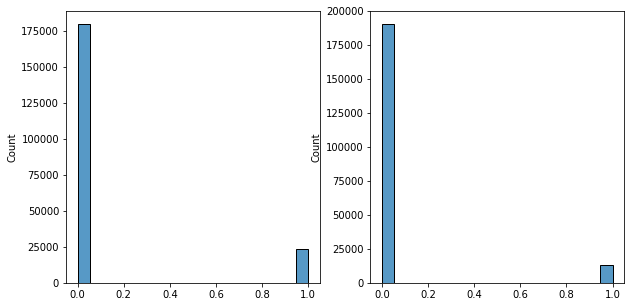

In [ ]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(10, 5)
sns.histplot(y_2019Q2[:,0], ax=axes[0])
sns.histplot(y_2019Q2[:,1], ax=axes[1])
plt.show()

In [ ]:
def gen_x(diff, date, t0):
  start = t0
  end = t0 + diff
  return date[(date.sale_date >= start) & (date.list_date < end)]

In [ ]:
class BaselineNet(nn.Module):
  def __init__(self, state_dim, output_dim, epochs=5000):
    super(BaselineNet, self).__init__()

    hidden_dim =  128
    self.linear1 = nn.Linear(state_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, output_dim)
    self.softmax = nn.Softmax(dim=1)
    
    self.epochs = epochs

  def forward(self, x):
    x = F.sigmoid(self.linear1(x))
    x = F.sigmoid(self.linear2(x))
    x = self.linear3(x)
    x = self.softmax(x)
    
    return x

  def feed(self, X, y):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
    cnt = 0

    for epoch in range(self.epochs):
      outputs = self.forward(X.float())
#       print(outputs)
      labels = torch.max(y, 1)[1]
      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      cnt += 1
      if cnt % 100 == 0:
        correct = 0
        total = y.shape[0]
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum()
        accuracy = 100 * correct/total
        print("Iteration: {}. Loss: {}. Correct: {}. Accuracy: {}.".format(cnt, loss.item(), correct, accuracy))

In [ ]:
def predict_on_timeframe(t0, days, df, cols_to_drop):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
  tmp = gen_x(datetime.timedelta(days = days), df, t0)
  Y = gen_y(datetime.timedelta(days = days), tmp, t0)[:,1]
  
  X = tmp.drop(columns=cols_to_drop, errors='ignore')
  X = X.reset_index(drop=True)
  
  print('X shape: {}, y shape: {}'.format(X.shape, Y.shape))
  
#   sm = SMOTE(random_state=42)
#   X, Y = sm.fit_resample(X, Y)
#   print('After SMOTE: X shape{}, y shape {}'.format(X.shape, Y.shape))
  
  print('Y: {}'.format(Y))
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
  
  clf = LogisticRegression(random_state=0).fit(X_train, y_train)
  print('roc_auc_score: ' + str(roc_auc_score(y_test, clf.predict(X_test)))) 
  print('Accuracy of logistic regression: {}'.format(clf.score(X_test, y_test)))
  
  sns.histplot(y_train)
  
  X_train = torch.tensor(X_train.astype(float).values, dtype=torch.float64).to(device)
  y_train = torch.tensor(y_train, dtype=torch.int64).to(device)
  y_train = torch.nn.functional.one_hot(y_train)
  
  print('y_train: {}'.format(y_train))
  net = BaselineNet(X_train.shape[1], y_train.shape[1], epochs=50000).to(device)
  
  net.train()
  net.feed(X_train, y_train)
  
  X_test = torch.tensor(X_test.astype(float).values, dtype=torch.float64).to(device)
  y_test = torch.tensor(y_test, dtype=torch.int64).to(device)
  y_test = torch.nn.functional.one_hot(y_test)
  
  with torch.no_grad():
    net.eval()
    outputs = net.forward(X_test.float())
    labels = torch.max(y_test, 1)[1]
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum()
    accuracy = 100 * correct/y_test.shape[0]

    print('Accuracy of neural network on test set: {}, correct: {}'.format(accuracy, correct))
    
  return net

In [ ]:
predict_on_timeframe(datetime.datetime(2019,4,1), 30, joined, cols_to_drop)

X shape: (13318, 55), y shape: (13318,)
Y: [0 1 1 ... 1 0 0]
roc_auc_score: 0.5
Accuracy of logistic regression: 0.7112627986348122
y_train: tensor([[1, 0],
        [0, 1],
        [1, 0],
        ...,
        [1, 0],
        [0, 1],
        [1, 0]], device='cuda:0')
Iteration: 100. Loss: 0.6028019189834595. Correct: 6355. Accuracy: 71.


/home/namluu/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 200. Loss: 0.6010628342628479. Correct: 6355. Accuracy: 71.
Iteration: 300. Loss: 0.6006020903587341. Correct: 6355. Accuracy: 71.
Iteration: 400. Loss: 0.6004132032394409. Correct: 6355. Accuracy: 71.
Iteration: 500. Loss: 0.6003187894821167. Correct: 6355. Accuracy: 71.
Iteration: 600. Loss: 0.6002650856971741. Correct: 6355. Accuracy: 71.
Iteration: 700. Loss: 0.6002323627471924. Correct: 6355. Accuracy: 71.
Iteration: 800. Loss: 0.6002113819122314. Correct: 6355. Accuracy: 71.
Iteration: 900. Loss: 0.6001973748207092. Correct: 6355. Accuracy: 71.
Iteration: 1000. Loss: 0.6001880764961243. Correct: 6355. Accuracy: 71.
Iteration: 1100. Loss: 0.6001808643341064. Correct: 6355. Accuracy: 71.
Iteration: 1200. Loss: 0.600176990032196. Correct: 6355. Accuracy: 71.
Iteration: 1300. Loss: 0.6001725792884827. Correct: 6355. Accuracy: 71.
Iteration: 1400. Loss: 0.6001702547073364. Correct: 6355. Accuracy: 71.
Iteration: 1500. Loss: 0.6001679301261902. Correct: 6355. Accuracy: 71.
I

Iteration: 11600. Loss: 0.6001608371734619. Correct: 6355. Accuracy: 71.
Iteration: 11700. Loss: 0.6001608371734619. Correct: 6355. Accuracy: 71.
Iteration: 11800. Loss: 0.6001607775688171. Correct: 6355. Accuracy: 71.
Iteration: 11900. Loss: 0.6001604795455933. Correct: 6355. Accuracy: 71.
Iteration: 12000. Loss: 0.6001607775688171. Correct: 6355. Accuracy: 71.
Iteration: 12100. Loss: 0.6001611351966858. Correct: 6355. Accuracy: 71.
Iteration: 12200. Loss: 0.6001614332199097. Correct: 6355. Accuracy: 71.
Iteration: 12300. Loss: 0.600161612033844. Correct: 6355. Accuracy: 71.
Iteration: 12400. Loss: 0.6001615524291992. Correct: 6355. Accuracy: 71.
Iteration: 12500. Loss: 0.6001614928245544. Correct: 6355. Accuracy: 71.
Iteration: 12600. Loss: 0.6001616716384888. Correct: 6355. Accuracy: 71.
Iteration: 12700. Loss: 0.6001614332199097. Correct: 6355. Accuracy: 71.
Iteration: 12800. Loss: 0.6001614332199097. Correct: 6355. Accuracy: 71.
Iteration: 12900. Loss: 0.6001611948013306. Correct:

Iteration: 23000. Loss: 0.6001594066619873. Correct: 6355. Accuracy: 71.
Iteration: 23100. Loss: 0.6001594662666321. Correct: 6355. Accuracy: 71.
Iteration: 23200. Loss: 0.6001593470573425. Correct: 6355. Accuracy: 71.
Iteration: 23300. Loss: 0.6001592874526978. Correct: 6355. Accuracy: 71.
Iteration: 23400. Loss: 0.6001593470573425. Correct: 6355. Accuracy: 71.
Iteration: 23500. Loss: 0.6001595854759216. Correct: 6355. Accuracy: 71.
Iteration: 23600. Loss: 0.6001597046852112. Correct: 6355. Accuracy: 71.
Iteration: 23700. Loss: 0.6001594662666321. Correct: 6355. Accuracy: 71.
Iteration: 23800. Loss: 0.6001594662666321. Correct: 6355. Accuracy: 71.
Iteration: 23900. Loss: 0.6001595258712769. Correct: 6355. Accuracy: 71.
Iteration: 24000. Loss: 0.6001586318016052. Correct: 6355. Accuracy: 71.
Iteration: 24100. Loss: 0.6001589894294739. Correct: 6355. Accuracy: 71.
Iteration: 24200. Loss: 0.6001589298248291. Correct: 6355. Accuracy: 71.
Iteration: 24300. Loss: 0.60015869140625. Correct: 

Iteration: 34400. Loss: 0.6001573801040649. Correct: 6355. Accuracy: 71.
Iteration: 34500. Loss: 0.6001573204994202. Correct: 6355. Accuracy: 71.
Iteration: 34600. Loss: 0.6001572012901306. Correct: 6355. Accuracy: 71.
Iteration: 34700. Loss: 0.6001571416854858. Correct: 6355. Accuracy: 71.
Iteration: 34800. Loss: 0.6001580953598022. Correct: 6355. Accuracy: 71.
Iteration: 34900. Loss: 0.6001580953598022. Correct: 6355. Accuracy: 71.
Iteration: 35000. Loss: 0.6001577973365784. Correct: 6355. Accuracy: 71.
Iteration: 35100. Loss: 0.6001576781272888. Correct: 6355. Accuracy: 71.
Iteration: 35200. Loss: 0.6001580357551575. Correct: 6355. Accuracy: 71.
Iteration: 35300. Loss: 0.6001574993133545. Correct: 6355. Accuracy: 71.
Iteration: 35400. Loss: 0.6001574993133545. Correct: 6355. Accuracy: 71.
Iteration: 35500. Loss: 0.6001574397087097. Correct: 6355. Accuracy: 71.
Iteration: 35600. Loss: 0.6001576781272888. Correct: 6355. Accuracy: 71.
Iteration: 35700. Loss: 0.6001579165458679. Correct

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1c850c61-d934-4c85-b16d-3cb283df0c84' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>